<a href="https://colab.research.google.com/github/CFIN-analysis/analysis_workshop_26May/blob/main/Notebooks/2_2_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Predicting from an HMM

This notebook explains how to use an HMM to predict individual traits. In our example, we use a Gaussian HMM trained on synthetic resting-state-like fMRI data, but the same methods can be used for other modalities and other varieties of the (GL)HMM. If you are unsure how to fit a (GL)HMM, it is a good idea to start with the tutorials for the [*Standard Gaussian Hidden Markov Model*](https://github.com/vidaurre/glhmm/blob/main/docs/notebooks/GaussianHMM_example.ipynb) (for one set of timeseries, e.g., recordings from neuroimaging/electrophysiology) or the [*Gaussian-Linear Hidden Markov Model*](https://github.com/vidaurre/glhmm/blob/main/docs/notebooks/GLHMM_example.ipynb) (for two sets of timeseries, e.g., recordings from neuroimaging/electrophysiology and behavioural timeseries).

We here demonstrate how you can use the toolbox for [regression](#predicting) and [classification](#classification) from HMMs using the built-in cross-validation (CV) functionality. Instead of using the built-in CV, you can also separately train and test the model, e.g. to use your own defined folds or if you want to only train/test the model. For an example, see the [*Predicting from an HMM in split data*](https://github.com/vidaurre/glhmm/blob/main/docs/notebooks/Prediction_split.ipynb) notebook. Simulated data and pre-trained HMMs are available from the [OSF project page](https://osf.io/8qcyj/?view_only=119c38072a724e0091db5ba377935666).

**Note:** Due to rendering issues when viewing this notebook through github, internal links, like the table of contents, may not work correctly. To ensure that the notebook renders correctly, you can view it through [this link](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/Prediction_tutorial.ipynb).

Authors: Christine Ahrends <christine.ahrends@cfin.au.dk>


## Outline
1. [Background](#background)
    * [The Fisher kernel](#background-fisher-kernel)
    * [Summary metrics](#background-summary-metrics)
2. [Preparation](#preparation)
    * [Load and prepare data](#load-data)
    * [Train or load pre-trained Gaussian HMM on fMRI data](#train-hmm)
        * [Inspecting model parameters](#inspect-parameters)
3. [Predicting individual traits from an HMM](#predicting)
    * [Predicting using the Fisher kernel](#example-fisher-kernel)
    * [Predicting using summary metrics](#example-summary-metrics)
    * [Classifying from HMMs](#classification)

## Background <a id="background"></a>
The HMM can be a useful description of patterns of brain dynamics across a group of subjects, and we may be interested in using this description to predict something about the individuals in this group. However, the information about individual brain dynamics given by the HMM needs to be extracted in a way that it can be used as features for regression or classification, and there are different approaches to doing that. The GLHMM toolbox currently includes two different ways of predicting or classifying individual traits from an HMM: the Fisher kernel and the summary metrics approach. 

### The Fisher kernel <a id="background-fisher-kernel"></a>
The Fisher kernel (Jaakkola & Haussler, 1998) is a mathematically principled approach that uses the entire set (or a selection) of HMM parameters and constructs from them a kernel, representing between-subject similarities. This kernel can be used in a straightforward and computationally efficient way in any kernel-based prediction or classifier. This approach has been shown to be more accurate and reliable than other methods, including other kernels constructed from HMM-parameters ([Ahrends, Woolrich, & Vidaurre, 2024](https://elifesciences.org/reviewed-preprints/95125)). 

The HMM parameters lie on a Riemannian manifold $R_\theta$, and the Fisher kernel uses a projection on this manifold. In that way, it preserves the structure of the HMM, which defines, e.g. how the state covariance would change if we were to change an entry in the transition probability matrix, and how a change of 0.1 in the transition probabilities is not the same as a change of 0.1 in the state means. Subjects/sessions are here defined in reference to the group-level model parameters. The kernel will describe two subjects as similar if we have to change the group-level HMM in a similar way to fit their timeseries, and as dissimilar if we have to change the group-level HMM in a different way to fit them. 

This mapping $x \rightarrow \phi(x)$ is done by using the Fisher score, which is the gradient of the log-likelihood with respect to each model parameter:

$$g(\theta^0, x^n)=\frac{\partial \log \mathcal{L}_\theta^0 (x^n)}{\partial \theta^0}$$

where $x^n$ is the timeseries of subject/session $n$, $\theta^0$ are the group-level HMM parameters, so $\mathcal{L}_\theta^0(x^n)=P(x^n|\theta^0)$ is the likelihood of the timeseries of subject $n$ given the group-level model parameters $\theta^0$. This maps each individual subject's timeseries into a point in the gradient space of the Riemannian manifold $R_\theta$ defined by the HMM parameters.

We here use the practical Fisher kernel, where the linear form is simply the inner product of a pair of subjects'/sessions' Fisher scores, e.g.. for subjects $n$ and $m$:

$$\mathcal{K}_{Fl}(n,m)=\langle {g(\theta^0, x^n), g(\theta^0, x^m)} \rangle$$

We can also use a Gaussian version of the Fisher kernel:

$$\mathcal{K}_{Fg}(n,m)=\exp(-\frac{||g(\theta^0, x^n)-g(\theta^0, x^m)||^2}{2\tau^2})$$

where $||g(\theta^0, x^n)-g(\theta^0, x^m)||$ is the distance between subjects/sessions $n$ and $m$ in the gradient space and $\tau$ is the width of the Gaussian kernel. 


### Summary metrics <a id="background-summary-metrics"></a>
Alternatively, you can predict individual traits from summary metrics. Compared to the Fisher kernel, this offers the advantage of being more interpretable, but it contains less information (since the Fisher kernel can use all parameters of the HMM, i.e. the full description) and, as we show below, it often produces less accurate results. 

The approach we have implemented here extracts one or more of the following summary metrics: 
* fractional occupancies (FO): the fraction of the entire timeseries occupied by each state for each subject/session
* switching rate: the average rate of switching between states (as opposed to staying in the same state)
* lifetimes: the average lifetime (duration) of a state in the timeseries, where shorter lifetimes indicate faster dynamics

Since this "feature-engineering" approach does not require us to work in a particular space, we can simply use these features in standard machine learning models. The same features can also be used for statistical testing. 

## Preparation <a id="preparation"></a>
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

In [ ]:
!pip install -q git+https://github.com/vidaurre/glhmm

**Import libraries**\
Let's start by importing the required libraries and modules.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glhmm import glhmm, preproc, prediction, io, graphics

### Load and prepare data <a id="load-data"></a>
Example data for this tutorial are available for download from the OSF. This notebook will fetch the relevant data from the OSF project page using the osfclient package. If you prefer, you can also directly download the files from the [OSF project page](https://osf.io/8qcyj/?view_only=119c38072a724e0091db5ba377935666) and skip the next two cells. 

In [2]:
# checks if osfclient is installed and otherwise installs it using pip install
# skip this if you have manually downloaded the data
import sys
import pip

def install(package):
    pip.main(['install', package])

try:
    import osfclient
except ImportError:
    print('osfclient is not installed, installing it now')
    install('osfclient')

In [3]:
! osf -p 8qcyj fetch Prediction/tc_forpred.csv ./data_prediction/tc_forpred.csv
! osf -p 8qcyj fetch Prediction/T_forpred.csv ./data_prediction/T_forpred.csv
! osf -p 8qcyj fetch Prediction/Y_forpred.csv ./data_prediction/Y_forpred.csv
! osf -p 8qcyj fetch Prediction/confounds_forpred.csv ./data_prediction/confounds_forpred.csv
! osf -p 8qcyj fetch Prediction/family_forpred.csv ./data_prediction/family_forpred.csv
! osf -p 8qcyj fetch Prediction/hmm_pred.pkl ./data_prediction/hmm_pred.pkl

usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/tc_forpred.csv already exists, not overwriting.
usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/T_forpred.csv already exists, not overwriting.
usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/Y_forpred.csv already exists, not overwriting.
usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/confounds_forpred.csv already exists, not overwriting.
usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/family_forpred.csv already exists, not overwriting.
usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/hmm_pred.pkl already exists, not overwriting.


This will created a folder called **data_prediction**. Load the following files from the folder:
* data: simulated resting-state-like fMRI timeseries: 4800 timepoints from 100 subjects in a parcellation with 50 ROIs
* behav: simulated behavioural item from 100 subjects
* T_t: indices for beginning and start of each subject's scanning session
* twins: matrix indicating family structure (subjects x subjects), zeros for unrelated subjects and positive values for related subjects (diagonal will be ignored)
* confounds: confounding variable for 100 subjects

In [4]:
# load data from csv files and convert to numpy arrays
data = pd.read_csv('./data_prediction/tc_forpred.csv', header=None).to_numpy()
T_t = pd.read_csv('./data_prediction/T_forpred.csv', header=None).to_numpy()
behav = np.squeeze(pd.read_csv('./data_prediction/Y_forpred.csv', header=None).to_numpy())
twins = pd.read_csv('./data_prediction/family_forpred.csv', header=None).to_numpy()
confounds = np.squeeze(pd.read_csv('./data_prediction/confounds_forpred.csv', header=None).to_numpy())

# check that dimensions of input files are correct:
print(data.shape) # data should be (n_subjects*n_timepoints, n_parcels)
print(behav.shape) # behav should be (n_subjects, n_variables)
print(T_t.shape) # T_t should be (n_subjects, 2)
print(twins.shape) # twins should be (n_subjects, n_subjects)
print(confounds.shape) # confounds should be (n_subjects, n_confounds) or (n_subjects,)

(480000, 50)
(100,)
(100, 2)
(100, 100)
(100,)


Standardise timeseries for all following computations. This is an important step, especially when looking at differences between individuals, to make sure that predictions are not driven by measurement noise.

In [5]:
data_preproc,_,_ = preproc.preprocess_data(data, T_t)

Plot the difference between the original and the standardised timeseries. In this case, the provided timecourses are already close to standardised so you should not see much of a difference, but in real data, this step is crucial.

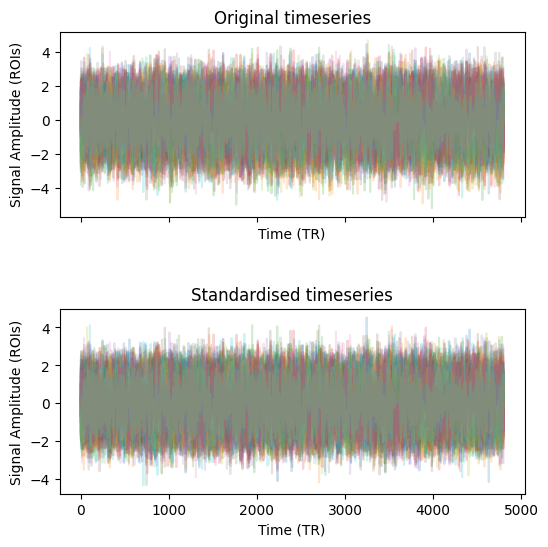

In [6]:
# for one example subject
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(data[0:4800,:], alpha=0.2)
ax0.set_xlabel("Time (TR)")
ax0.set_ylabel("Signal Amplitude (ROIs)")
ax0.title.set_text("Original timeseries")
ax1.plot(data_preproc[0:4800,:], alpha=0.2)
ax1.set_xlabel("Time (TR)")
ax1.set_ylabel("Signal Amplitude (ROIs)")
ax1.title.set_text("Standardised timeseries")
plt.subplots_adjust(hspace=0.5)
plt.show()

In [7]:
# delete non-standardised data to save memory
del data

### Train or load pre-trained Gaussian HMM on fMRI data <a id="train-hmm"></a>

Load the pre-trained HMM, provided in the example folder. Here, we have trained the HMM using a Gaussian observation model with mean and covariance for 6 states. Note that this HMM has been fitted to all subjects' timeseries. Depending on your question, it may be necessary to split the dataset into training and test folds before training the group-level model to avoid data leakage. However, note that this will affect the Fisher kernel differently, since the features of the subjects are not independent but are always defined in reference to the group-level model (see [Ahrends, Woolrich, & Vidaurre, 2025](https://elifesciences.org/articles/95125) for details).

In [43]:
# %%capture
# np.random.seed(1234)
# hmm = glhmm.glhmm(model_beta='no', K=6, covtype='full')
# hmm.train(X=None, Y=data_preproc, indices=T_t)

In [50]:
# import pickle
# with open('./data_prediction/hmm_pred.pkl', 'wb') as outp:
#     pickle.dump(hmm, outp, pickle.HIGHEST_PROTOCOL)

In [51]:
hmm = io.load_hmm('./data_prediction/hmm_pred.pkl')

For details on training from scratch, follow the tutorials [*Standard Gaussian Hidden Markov Model*](https://github.com/vidaurre/glhmm/blob/main/docs/notebooks/GaussianHMM_example.ipynb) or [*Gaussian-Linear Hidden Markov Model*](https://github.com/vidaurre/glhmm/blob/main/docs/notebooks/GLHMM_example.ipynb). 

#### Inspecting model parameters <a id="inspect-parameters"></a>

First, let's check the HMM parameter estimates, which we will use to predict individual traits. In this case, we have simulated data where one of the states' mean is correlated with the target variable, with the addition of noise. The state covariances are kept the same for simplicity in this example. Note that it is not necessary for the true features of interest to be the state means but they can be any of the HMM parameters.

In [52]:
K = hmm.hyperparameters["K"] # the number of states
q = data_preproc.shape[1] # the number of parcels/channels
init_stateP = hmm.Pi.copy() # the initial state probabilities
TP = np.zeros(shape=(K, K))
TP = hmm.P.copy() # the transition probability matrix
state_means = np.zeros(shape=(q, K))
state_means = hmm.get_means() # the state means in the shape (no. features, no. states)
state_FC = np.zeros(shape=(q, q, K))
for k in range(K):
    state_FC[:,:,k] = hmm.get_covariance_matrix(k=k) # the state covariance matrices in the shape (no. features, no. features, no. states)

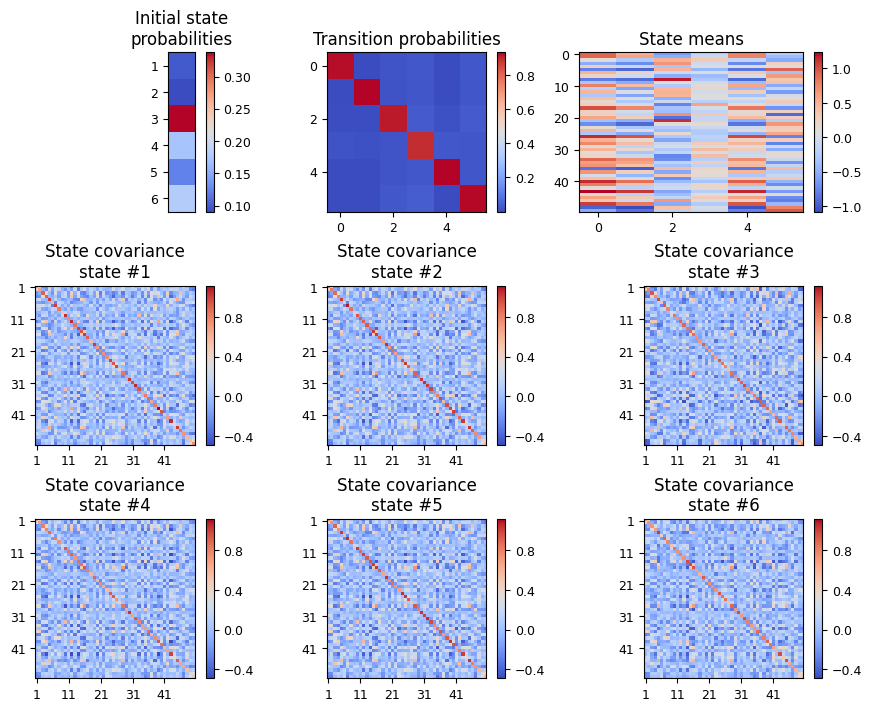

In [53]:
# Plot the HMM parameter estimates
graphics.plot_state_prob_and_covariance(init_stateP, TP, state_means, 
                                        state_FC, cmap='coolwarm')

## Predicting individual traits from an HMM using cross-validation <a id="predicting"></a>

To predict from an HMM using cross-validation, you can use the function `predict_phenotype` from the prediction module. This function goes through the following steps:
1. create the Fisher kernel or extract summary metrics from a group-level HMM (the features are normalised or the kernel is centered during CV)
2. fit prediction model:
    using nested cross-validation, where the inner CV loops are used to optimise hyperparameters via grid search.   
    (optionally) deconfounding during CV, otherwise the target variables are only normalised (also during CV)\
    (optionally) accounting for group/family structure so that related subjects are never split across folds
3. predict on test set
4. evaluate predictive performance

The function uses as input a pretrained HMM (`hmm`), the neuroimaging timeseries of a group of subjects (`Y`), the variable/phenotype from the same group of subjects that you want to predict (`behav`), as well as indices specifying the start and end of each individual in the timeseries (`indices`). It returns the model-predicted values for the variable, the correlation coefficient between the model-predicted and the actual values, and other optional output if requested. The approach (Fisher kernel or summary metrics) is specified using the `predictor` argument. The estimator can also be provided using the `estimator` argument and will otherwise default to kernel ridge regression when using the Fisher kernel approach and to ridge regression when using the summary metrics approach. All other relevant options can be specified by providing a dictionary for the `options` argument. 


### Predicting using the Fisher kernel <a id="example-fisher-kernel"></a>
The Fisher kernel allows using either all or a selection of HMM parameters for a prediction/classification, and it is constructed from the HMM in a mathematically principled manner that preserves the underlying structure of the model parameters. This approach is recommended because it tends to predict more accurately and does so more robustly than other methods (see [Ahrends, Woolrich, & Vidaurre, 2025](https://elifesciences.org/articles/95125) for details.)

In [55]:
np.random.seed(1234)

options = {}
# general options:
options['nfolds'] = 10 # number of folds for inner & outer CV loops
options['group_structure'] = twins # group structure that CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# when not using group/family structure, simply don't specify this option
options['confounds'] = confounds # confounding variables (here sex and head motion)
# when not using confounds, simply don't specify this option
# optional outputs:
options['return_scores'] = True
options['return_models'] = True
options['return_hyperparams'] = True
# Fisher kernel options:
options['shape'] = 'linear'
options['incl_Mu'] = True # include state means
options['incl_Sigma'] = True # include state covariances
# the initial state probabilities and the transition probabilities
# are used by default, but can be excluded by setting options['incl_Pi']
# and options['incl_P'], respectively, to False

# use HMM trained/loaded above and standardised timeseries to predict subjects' age:
pred_FK = prediction.predict_phenotype(hmm, data_preproc, behav, T_t, predictor='Fisherkernel', estimator='KernelRidge', options=options)

`pred_FK` contains the out-of-sample predictions for the target variable (both in deconfounded and original space) and the correlation between the model-predicted and the actual ages of subjects (`corr`). Additionally, we have here requested the output to also contain the coefficients of determination of each fold (`scores`), the estimated hyperparameters of each fold - in this case the regularisation parameters alpha (`hyperparams`), and the trained models themselves (`models`).

In [56]:
print(pred_FK['corr_deconf']) # the correlation coefficient
print(pred_FK['scores_deconf']) # the coefficients of determination
print(pred_FK['hyperparams']) # the regularisation parameters
pred_FK['models'][0] # the first estimated model

0.7783490439947173
[0.5663047641327257, 0.675526103108109, 0.5218506988431226, 0.6855077280928329, 0.12427579370655184, 0.0800697018972365, 0.5400409044227892, 0.7119990695249923, 0.5199562948389401, 0.17932807065555678]
[0.1, 0.1, 0.1, 0.0001, 0.1, 0.1, 0.0001, 0.0001, 0.1, 0.1]


GridSearchCV(cv=GroupKFold(n_splits=10),
             estimator=KernelRidge(kernel='precomputed'),
             param_grid={'alpha': array([0.0001    , 0.00039811, 0.00158489, 0.00630957, 0.02511886,
       0.1       ])})

Plot true vs. predicted variable:

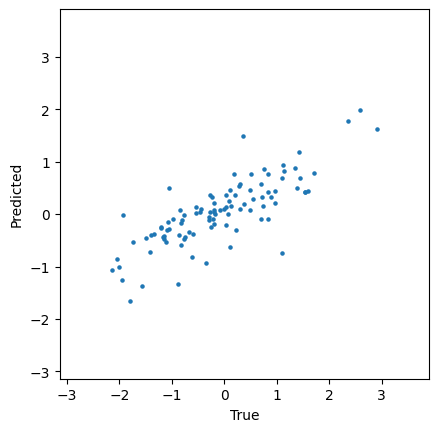

In [57]:
plt.scatter(behav, pred_FK['behav_pred'], s=5, color='tab:blue')
minval = min((min(behav), min(pred_FK['behav_pred'])))
maxval = max((max(behav), max(pred_FK['behav_pred'])))
plt.xlim((minval-1),(maxval+1))
plt.ylim((minval-1),(maxval+1))
plt.gca().set_xlabel('True')
plt.gca().set_ylabel('Predicted')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Predicting using summary metrics <a id="example-summary-metrics"></a>

The second option is to extract summary metrics from a trained HMM and use these as features for a prediction. Which metrics to include should be specified in `options['metrics']`. At the moment, possible summary metrics include state fractional occupancies (`'FO'`), lifetimes (`'lifetimes'`), and switching rates (`'switching_rate'`). 

In [58]:
np.random.seed(1234)

options = {}
# general options:
options['nfolds'] = 10 # number of folds for inner & outer CV loops
options['group_structure'] = twins # group structure that CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# when not using group/family structure, simply don't specify this option
options['confounds'] = confounds # confounding variables (here sex and head motion)
# when not using confounds, simply don't specify this option
# optional outputs:
options['return_scores'] = True
options['return_models'] = True
options['return_hyperparams'] = True
# summary metrics options:
options['metrics'] = ('FO', 'lifetimes', 'switching_rate')
# include the fractional occupancies (FO), the state lifetimes, and the switching rates

# use HMM trained/loaded above and standardised timeseries to predict subjects' age:
pred_summ = prediction.predict_phenotype(hmm, data_preproc, behav, T_t, predictor='summary_metrics', estimator='Ridge', options=options)

In [59]:
print(pred_summ['corr_deconf'])
print(pred_summ['scores_deconf'])
print(pred_summ['hyperparams'])
pred_summ['models'][0]

0.6844730849507883
[0.8196326837765134, 0.6556006635893736, 0.6318403750953928, 0.5050886061900627, 0.20994144770628465, -0.1239641901192865, 0.44175628484667295, 0.4082909797161497, 0.5725746913656045, -2.6045694756701554]
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


GridSearchCV(cv=GroupKFold(n_splits=10), estimator=Ridge(),
             param_grid={'alpha': array([0.0001    , 0.00039811, 0.00158489, 0.00630957, 0.02511886,
       0.1       ])})

Plot actual vs. predicted variable

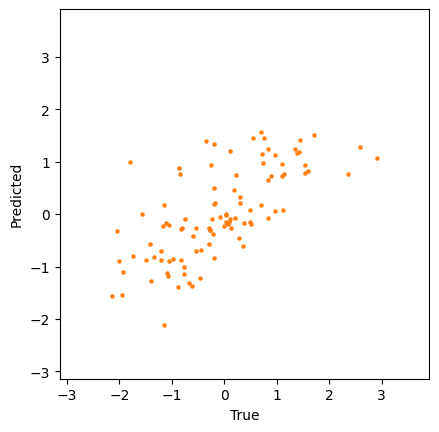

In [60]:
plt.scatter(behav, pred_summ['behav_pred'], s=5, color='tab:orange')
minval = min((min(behav), min(pred_summ['behav_pred'])))
maxval = max((max(behav), max(pred_summ['behav_pred'])))
plt.xlim((minval-1),(maxval+1))
plt.ylim((minval-1),(maxval+1))
plt.gca().set_xlabel('True')
plt.gca().set_ylabel('Predicted')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

We can plot the difference in accuracies between the Fisher kernel and the summary metrics approach for the regression problem:

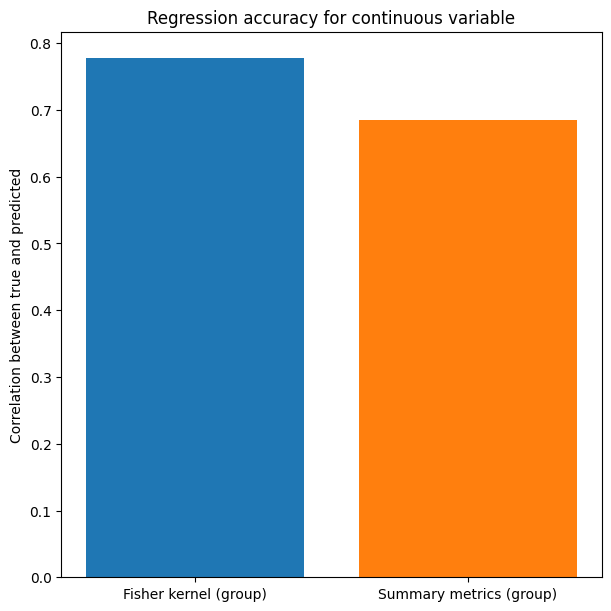

In [61]:
fig, ax = plt.subplots(layout="constrained", figsize=(6, 6))
features = ["Fisher kernel (group)", "Summary metrics (group)"]
pred_acc = [pred_FK['corr_deconf'], pred_summ['corr_deconf']]
bar_colors = ['tab:blue', 'tab:orange']
ax.bar(features, pred_acc, color=bar_colors)
ax.set_ylabel('Correlation between true and predicted')
ax.set_title('Regression accuracy for continuous variable')
plt.show()

### Classifying from HMMs <a id="classification"></a>

Analogous to `predict_phenotype`, the function `classify_phenotype` allows classifying from an HMM. We have simulated timecourses for two groups of subjects, where the first 50 subjects belong to group 1 and the second 50 subjects belong to group 2. As in the regression problem above, we have simulated the effect to be in one of the state means (but making sure that the difference is small enough that the state does not occur exclusively in one of the groups). As opposed to the simulated data above, there is no additional between-subject noise, so the group difference should be fairly obvious. 

In [62]:
! osf -p 8qcyj fetch Prediction/tc_forclass.csv ./data_prediction/tc_forclass.csv
! osf -p 8qcyj fetch Prediction/T_forpred.csv ./data_prediction/T_forpred.csv
! osf -p 8qcyj fetch Prediction/Y_forpred.csv ./data_prediction/Y_forpred.csv
! osf -p 8qcyj fetch Prediction/confounds_forpred.csv ./data_prediction/confounds_forpred.csv
! osf -p 8qcyj fetch Prediction/family_forpred.csv ./data_prediction/family_forpred.csv
! osf -p 8qcyj fetch Prediction/hmm_class.pkl ./data_prediction/hmm_class.pkl

100%|████████████████████████████████████| 109M/109M [00:07<00:00, 15.5Mbytes/s]
usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/T_forpred.csv already exists, not overwriting.
usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/Y_forpred.csv already exists, not overwriting.
usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/confounds_forpred.csv already exists, not overwriting.
usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/family_forpred.csv already exists, not overwriting.
100%|████████████████████████████████████| 408k/408k [00:00<00:00, 5.50Mbytes/s]


In [63]:
data_c = pd.read_csv('./data_prediction/tc_forclass.csv', header=None).to_numpy()
group = np.ones(100)
group[50:100] = 2 # create classes: the first 50 subjects are group 1, the second 50 subjects are group 2
T = np.repeat(1200,100) # we have simulated 100 subjects with 1200 timepoints each
T_tc = glhmm.auxiliary.make_indices_from_T(T)

In [64]:
data_c_preproc,_,_ = preproc.preprocess_data(data_c, T_tc)
del data_c

In [65]:
# %%capture
# np.random.seed(1234)
# hmm_c = glhmm.glhmm(model_beta='no', K=6, covtype='full')
# hmm_c.train(X=None, Y=data_c_preproc, indices=T_tc)

In [70]:
# import pickle
# with open('./data_prediction/hmm_class.pkl', 'wb') as outp:
#     pickle.dump(hmm_c, outp, pickle.HIGHEST_PROTOCOL)

In [71]:
hmm_c = io.load_hmm('./data_prediction/hmm_class.pkl')

We will first classify using the Fisher kernel approach:

In [66]:
np.random.seed(1234)

options = {}
# general options:
options['nfolds'] = 10 # number of folds for inner & outer CV loops
options['group_structure'] = twins # group structure that CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# optional outputs:
options['return_scores'] = True
options['return_models'] = True
options['return_hyperparams'] = True
options['return_prob'] = True # for classification, you can optionally also return the probabilities for each class, but note that this will take longer
# Fisher kernel options:
options['shape'] = 'linear'
options['incl_Mu'] = True # include state means
options['incl_Sigma'] = True # include state covariances

# use HMM trained/loaded above and standardised timeseries to classify sex using Fisher kernel method:
classif_FK = prediction.classify_phenotype(hmm_c, data_c_preproc, group, T_tc, predictor='Fisherkernel', estimator='SVM', options=options)

In [67]:
print(classif_FK['acc'])

1.0


In this artificial dataset, the Fisher kernel can thus classify the groups at 100% accuracy. Again, since there is no between-subject noise, this is expected to be an easy classification problem. If we use the summary metrics approach on the other hand, the features cannot directly access an effect like the one we have simulated (where one state's mean is different between the two groups). It may only indirectly be represented, e.g. in the state fractional occupancies.

To classify based on summary features, we need to set the `predictor` argument to `summary_metrics`:

In [68]:
np.random.seed(1234)

options = {}
# general options:
options['nfolds'] = 10 # number of folds for inner & outer CV loops
options['group_structure'] = twins # group structure that CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# optional outputs:
options['return_scores'] = True
options['return_models'] = True
options['return_hyperparams'] = True
options['return_prob'] = True # for classification, you can optionally also return the probabilities for each class, but note that this will take longer
# summary metrics options:
options['metrics'] = ('FO', 'lifetimes', 'switching_rate')

# use HMM trained/loaded above and standardised timeseries to classify sex from summary metrics:
classif_summ = prediction.classify_phenotype(hmm_c, data_c_preproc, group, T_tc, predictor='summary_metrics', estimator='LogisticRegression', options=options)

In [69]:
print(classif_summ['acc'])

0.63


The classification accuracy of the summary metrics approach is around 63%, indicating that this approach is not fully able to recover the effect of interest. The performance of the summary metrics approach would be better if there were, for instance, states that are occur more often in one of the groups.

Plot the overall classification accuracy

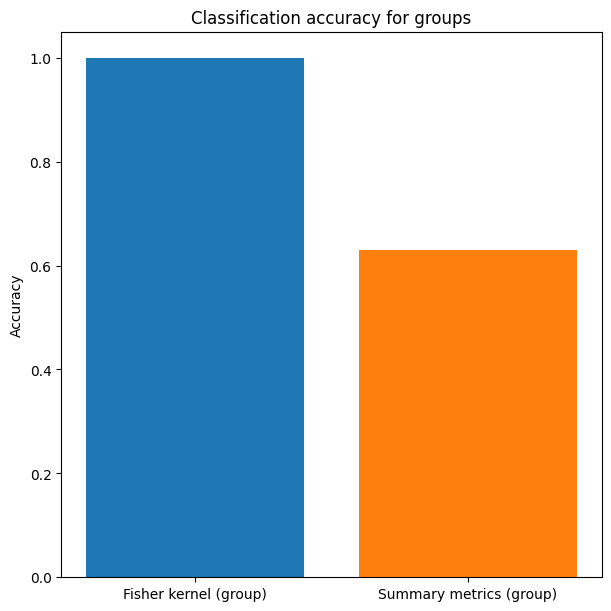

In [72]:
fig, ax = plt.subplots(layout="constrained", figsize=(6, 6))
features = ["Fisher kernel (group)", "Summary metrics (group)"]
classif_acc = [classif_FK['acc'], classif_summ['acc']]
bar_colors = ['tab:blue', 'tab:orange']
ax.bar(features, classif_acc, color=bar_colors)
ax.set_ylabel('Accuracy')
ax.set_title('Classification accuracy for groups')
plt.show()

Finally, combine all previous plots into a figure comparing prediction accuracy and classification accuracy using Fisher kernel approach vs. summary metrics approach:

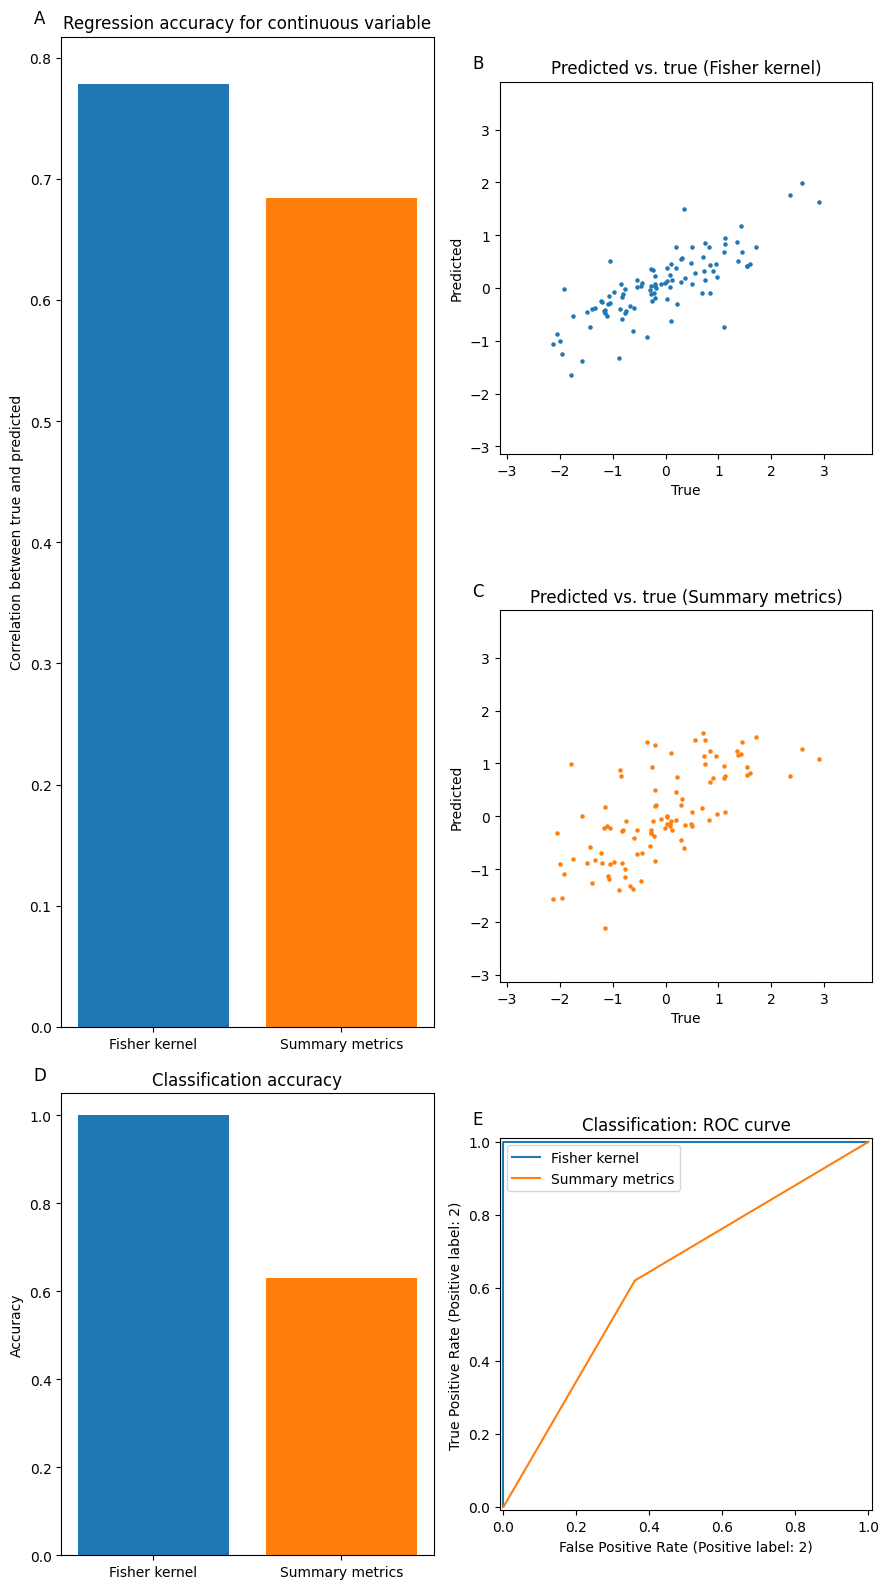

In [73]:
import matplotlib.transforms as mtransforms
import sklearn.metrics as ms
fig, axs = plt.subplot_mosaic([['A', 'B'], ['A', 'C'], ['D', 'E']], figsize=(9, 16))
for label, ax in axs.items():
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
    
# Prediction accuracy 
features = ["Fisher kernel", "Summary metrics"]
pred_acc = [pred_FK['corr_deconf'], pred_summ['corr_deconf']]
bar_colors = ['tab:blue', 'tab:orange']
axs['A'].bar(features, pred_acc, color=bar_colors)
axs['A'].set_ylabel('Correlation between true and predicted')
axs['A'].set_title('Regression accuracy for continuous variable')

# Scatter plot: Fisher kernel
axs['B'].scatter(behav, pred_FK['behav_pred'], s=5, color='tab:blue')
minval = min((min(behav), min(pred_FK['behav_pred'])))
maxval = max((max(behav), max(pred_FK['behav_pred'])))
axs['B'].set_xlim((minval-1),(maxval+1))
axs['B'].set_xlabel('True')
axs['B'].set_ylim((minval-1),(maxval+1))
axs['B'].set_ylabel('Predicted')
axs['B'].set_aspect('equal', adjustable='box')
axs['B'].set_title('Predicted vs. true (Fisher kernel)')

# Scatter plot: Summary metrics
axs['C'].scatter(behav, pred_summ['behav_pred'], s=5, color='tab:orange')
minval = min((min(behav), min(pred_summ['behav_pred'])))
maxval = max((max(behav), max(pred_summ['behav_pred'])))
axs['C'].set_xlim((minval-1),(maxval+1))
axs['C'].set_xlabel('True')
axs['C'].set_ylim((minval-1),(maxval+1))
axs['C'].set_ylabel('Predicted')
axs['C'].set_aspect('equal', adjustable='box')
axs['C'].set_title('Predicted vs. true (Summary metrics)')

features = ["Fisher kernel", "Summary metrics"]
classif_acc = [classif_FK['acc'], classif_summ['acc']]
bar_colors = ['tab:blue', 'tab:orange']
axs['D'].bar(features, classif_acc, color=bar_colors)
axs['D'].set_ylabel('Accuracy')
axs['D'].set_title('Classification accuracy')

# ROC plots Classification
axs['E'] = plt.gca()
rocdisp_FK = ms.RocCurveDisplay.from_predictions(group, classif_FK['behav_pred'], ax=axs['E'], color='tab:blue', pos_label=2)
rocdisp_summ = ms.RocCurveDisplay.from_predictions(group, classif_summ['behav_pred'], ax=axs['E'], color='tab:orange', pos_label=2)
axs['E'].legend((features))
axs['E'].set_title('Classification: ROC curve')

plt.tight_layout()
plt.show()
